# Actividad - Proyecto práctico

> La actividad se desarrollará en grupos pre-definidos de 2-3 alumnos. Se debe indicar los nombres en orden alfabético (de apellidos). Recordad que esta actividad se corresponde con un 30% de la nota final de la asignatura. Se debe entregar entregar el trabajo en la presente notebook.
* Alumno 1: Benali, Abdelilah 
* Alumno 2: Cuesta Cifuentes, Jair 
* Alumno 3: González Huete, Manel
* Alumno 4: Manzanas Mogrovejo, Francisco
* Alumno 5: Pascual, Guadalupe

---
## **PARTE 1** - Instalación y requisitos previos

> Las prácticas han sido preparadas para poder realizarse en el entorno de trabajo de Google Colab. Sin embargo, esta plataforma presenta ciertas incompatibilidades a la hora de visualizar la renderización en gym. Por ello, para obtener estas visualizaciones, se deberá trasladar el entorno de trabajo a local. Por ello, el presente dosier presenta instrucciones para poder trabajar en ambos entornos. Siga los siguientes pasos para un correcto funcionamiento:
1.   **LOCAL:** Preparar el enviroment, siguiendo las intrucciones detalladas en la sección *1.1.Preparar enviroment*.
2.  **AMBOS:** Modificar las variables "mount" y "drive_mount" a la carpeta de trabajo en drive en el caso de estar en Colab, y ejecturar la celda *1.2.Localizar entorno de trabajo*.
3. **COLAB:** se deberá ejecutar las celdas correspondientes al montaje de la carpeta de trabajo en Drive. Esta corresponde a la sección *1.3.Montar carpeta de datos local*.
4.  **AMBOS:** Instalar las librerías necesarias, siguiendo la sección *1.4.Instalar librerías necesarias*.


---
### 1.1. Preparar enviroment (solo local)



> Para preparar el entorno de trabajo en local, se han seguido los siguientes pasos:
1. En Windows, puede ser necesario instalar las C++ Build Tools. Para ello, siga los siguientes pasos: https://towardsdatascience.com/how-to-install-openai-gym-in-a-windows-environment-338969e24d30.
2. Instalar Anaconda
3. Siguiendo el código que se presenta comentado en la próxima celda: Crear un enviroment, cambiar la ruta de trabajo, e instalar librerías básicas.


```
conda create --name miar_rl python=3.8
conda activate miar_rl
cd "PATH_TO_FOLDER"
conda install git
pip install jupyter
```


4. Abrir la notebook con *jupyter-notebook*.



```
jupyter-notebook
```


---
### 1.2. Localizar entorno de trabajo: Google colab o local

In [ ]:
# ATENCIÓN!! Modificar ruta relativa a la práctica si es distinta (drive_root)
mount='/content/gdrive'
drive_root = mount + "/My Drive/08_MIAR/actividades/proyecto practico"

try:
  from google.colab import drive
  IN_COLAB=True
except:
  IN_COLAB=False

---
### 1.3. Montar carpeta de datos local (solo Colab)

In [ ]:
# Switch to the directory on the Google Drive that you want to use
import os
if IN_COLAB:
  print("We're running Colab")

  if IN_COLAB:
    # Mount the Google Drive at mount
    print("Colab: mounting Google drive on ", mount)

    drive.mount(mount)

    # Create drive_root if it doesn't exist
    create_drive_root = True
    if create_drive_root:
      print("\nColab: making sure ", drive_root, " exists.")
      os.makedirs(drive_root, exist_ok=True)

    # Change to the directory
    print("\nColab: Changing directory to ", drive_root)
    %cd $drive_root
# Verify we're in the correct working directory
%pwd
print("Archivos en el directorio: ")
print(os.listdir())

---
### 1.4. Instalar librerías necesarias

In [ ]:
IN_LOCAL = True

if IN_COLAB:
  %pip install gym==0.17.3
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install keras-rl2==1.0.5
  %pip install tensorflow==2.8
if not IN_LOCAL:
  %pip install numpy==1.23.5
  %pip install gym==0.17
  %pip install git+https://github.com/Kojoley/atari-py.git
  %pip install pyglet==1.5.0
  %pip install h5py==3.1.0
  %pip install Pillow==9.5.0
  %pip install keras-rl2==1.0.5
  %pip install Keras==2.2.4
  %pip install tensorflow==2.5.3
  %pip install torch==2.0.1
  %pip install agents==1.4.0
  %pip install matplotlib==3.4.3
  %pip install tqdm

---
## **PARTE 2**. Enunciado

Consideraciones a tener en cuenta:

- El entorno sobre el que trabajaremos será _SpaceInvaders-v0_ y el algoritmo que usaremos será _DQN_.

- Para nuestro ejercicio, el requisito mínimo será alcanzado cuando el agente consiga una **media de recompensa por encima de 20 puntos en modo test**. Por ello, esta media de la recompensa se calculará a partir del código de test en la última celda del notebook.

Este proyecto práctico consta de tres partes:

1.   Implementar la red neuronal que se usará en la solución
2.   Implementar las distintas piezas de la solución DQN
3.   Justificar la respuesta en relación a los resultados obtenidos

**Rúbrica**: Se valorará la originalidad en la solución aportada, así como la capacidad de discutir los resultados de forma detallada. El requisito mínimo servirá para aprobar la actividad, bajo premisa de que la discusión del resultado sera apropiada.

IMPORTANTE:

* Si no se consigue una puntuación óptima, responder sobre la mejor puntuación obtenida.
* Para entrenamientos largos, recordad que podéis usar checkpoints de vuestros modelos para retomar los entrenamientos. En este caso, recordad cambiar los parámetros adecuadamente (sobre todo los relacionados con el proceso de exploración).
* Se deberá entregar unicamente el notebook y los pesos del mejor modelo en un fichero .zip, de forma organizada.
* Cada alumno deberá de subir la solución de forma individual.

---
## **PARTE 3**. Desarrollo y preguntas

#### Importar librerías

In [ ]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import gc       # Para garbage collection
import random
import os
import pickle
import re       # Para expresiones regulares en carga de checkpoints
import gym      # Para el entorno de Atari
import cv2     # Para preprocesamiento de imágenes si se usa AtariProcessor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Dense, Activation, Flatten, Convolution2D, Permute
from tensorflow.keras.layers import Lambda, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy
from rl.core import Processor
from rl.callbacks import FileLogger, ModelIntervalCheckpoint
from collections import deque
from tqdm import trange     # Necesaria para la barra de progreso en simple_train
import tensorflow.keras.backend as K

In [ ]:

# Necesario para la grabación de video
try:
    import gym.wrappers
except ImportError:
    print("WARNING: gym.wrappers no está disponible. La grabación de video no funcionará.")
    gym.wrappers = None # Asegurar que no dé error si no se encuentra


In [ ]:
# Configurar TensorFlow para CPU (14 cores)
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"

# Ajuste recomendado (seguro y eficiente)
tf.config.threading.set_intra_op_parallelism_threads(8)   # dentro de cada operación
tf.config.threading.set_inter_op_parallelism_threads(4)   # entre operaciones

#### Crear el entorno
Nuestro entorno es el juego Space Invaders, de Atari

In [7]:
# Create our environment
env_name = 'SpaceInvaders-v0'
env = gym.make(env_name)

np.random.seed(123)
env.seed(123)
nb_actions = env.action_space.n

D:\90-Tools\anaconda3\envs\mghMiar08\lib\site-packages\gym\logger.py:30: UserWarning: WARN: obs_type "image" should be replaced with the image type, one of: rgb, grayscale
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [8]:
print("El tamaño de nuestro 'frame' es: ", env.observation_space)
print("El número de acciones posibles es : ", nb_actions)
print("Las acciones posibles son : ",env.env.get_action_meanings())

# Here we create an hot encoded version of our actions
# possible_actions = [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0, 0]...]
possible_actions = np.array(np.identity(env.action_space.n,dtype=int).tolist())
print("\nOHE de las acciones posibles: \n", possible_actions)

El tamaño de nuestro 'frame' es:  Box(0, 255, (210, 160, 3), uint8)
El número de acciones posibles es :  6
Las acciones posibles son :  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

OHE de las acciones posibles: 
 [[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


#### Definición Hiperparámetros

In [9]:
### HIPERPARÁMETROS DEL MODELO
INPUT_SHAPE = (84, 84)
state_size = [84, 84, 3]          # Nuestra entrada es una pila de 4 fotogramas, por lo tanto 110x84x4 (ancho, alto, canales)
action_size = env.action_space.n  # 6 acciones posibles
learning_rate =  0.00025          # Alfa (también conocido como tasa de aprendizaje)

### HIPERPARÁMETROS DE ENTRENAMIENTO
# total_episodios = 10    #TEST        # Episodios totales para el entrenamiento
# max_steps = 10000       #TEST        # Máximo de pasos posibles por episodio
total_episodios = 100          # Episodios totales para el entrenamiento
max_steps = 3000               # Máximo de pasos posibles por episodio
batch_size = 32                # Tamaño del lote (batch)

# Parámetros de exploración para la estrategia epsilon-greedy
epsilon_start = 1.0            # Probabilidad de exploración al inicio
epsilon_stop = 0.01            # Probabilidad mínima de exploración
decay_rate = 0.00001           # Tasa de decaimiento exponencial para la probabilidad de exploración
epsilon_decay = 0.995

# Hiperparámetros del aprendizaje Q
gamma = 0.95                   # Tasa de descuento
tau = 0.001
checkpoint_path="checkpoints"

### HIPERPARÁMETROS DE MEMORIA
pretrain_length = batch_size   # Número de experiencias almacenadas en la memoria al inicializar por primera vez
memory_size = 5000             # Número de experiencias que la memoria puede guardar

### HIPERPARÁMETROS DE PREPROCESAMIENTO
WINDOW_LENGTH = 3              # Número de fotogramas apilados

### CAMBIA ESTO A FALSE SI SOLO QUIERES VER AL AGENTE ENTRENADO
training = False

## CAMBIA ESTO A TRUE SI QUIERES RENDERIZAR EL ENTORNO
episode_render = False

#### Clase "processor" para Atari

Ahora definimos un "processor" para las pantallas de entrada del juego, en el que recortamos el tamaño de la imagen (matriz de 210 x 160 píxeles) y la convertimos En una matriz bidimensional de 80 x 80 píxeles). También convertimos las imágenes de RGB a escala de grises normal, ya que no necesitamos usar los colores. Con este trabajo buscamos acelerar nuestro algoritmo, eliminando la información innecesaria y reduciendo la carga de la GPU.

In [10]:
class AtariProcessor(Processor):
    """
    Procesador para preprocesar observaciones del entorno Atari (e.g., SpaceInvaders-v0).

    Hereda de rl.core.Processor y proporciona métodos para convertir observaciones RGB en
    imágenes en escala de grises, redimensionarlas y normalizarlas, así como para limitar
    las recompensas.

    MÉTODOS:
    --------
        process_observation(observation): Convierte una observación RGB a escala de grises
                                         y la redimensiona.
        process_state_batch(batch): Normaliza un lote de estados dividiendo por 255.
        process_reward(reward): Limita las recompensas a un rango [-1, 1].
    """    
    def process_observation(self, observation):
        """
        Preprocesa una observación convirtiéndola a escala de grises y redimensionándola.

        Parámetros:
        -----------
            observation (np.ndarray): Observación cruda del entorno con forma (height, width, channels).

        Retorna:
        --------
            np.ndarray: Imagen en escala de grises redimensionada a INPUT_SHAPE (84, 84) en formato uint8.

        Raises:
            AssertionError: Si la observación no tiene 3 dimensiones o la forma procesada no coincide con INPUT_SHAPE.
        """
        assert observation.ndim == 3  # (height, width, channel)
        img = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        img = cv2.resize(img, INPUT_SHAPE, interpolation=cv2.INTER_AREA)
        processed_observation = np.array(img)
        assert processed_observation.shape == INPUT_SHAPE
        return processed_observation.astype('uint8')
    
    def process_state_batch(self, batch):
        """
        Normaliza un lote de estados dividiendo los valores por 255.

        Parámetros:
        -----------
            batch (np.ndarray): Lote de estados con valores en [0, 255].

        Retorna:
        --------
            np.ndarray: Lote normalizado con valores en [0, 1] en formato float32.
        """
        processed_batch = batch.astype('float32') / 255.
        return processed_batch

    def process_reward(self, reward):
        """
        Limita las recompensas a un rango [-1, 1].

        Parámetros:
        -----------
            reward (float): Recompensa cruda del entorno.

        Retorna:
        --------
            float: Recompensa limitada en el rango [-1, 1].
        """
        return np.clip(reward, -1., 1.)
    

    def process_step(self, reward, terminal, metrics):
        return self.process_reward(reward), terminal, metrics    
    
    def process_action(self, action):
        return action    

#### Revisar el entorno de juego

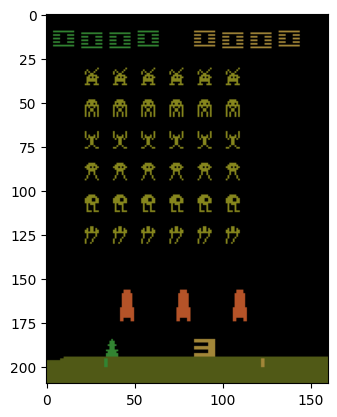

In [11]:
import matplotlib.pyplot as plt

observation = env.reset()
for i in range(22): 
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, reward, done, info = env.step(1)

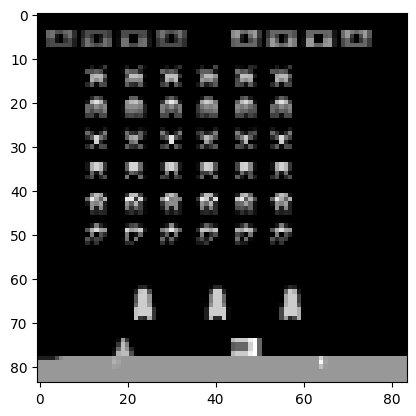

(210, 160, 3)
(84, 84)


In [12]:
# Mostrar las entradas preprocesadas en escala de grises y comparar originales y preprocesados.
processor = AtariProcessor()
obs_preprocessed = processor.process_observation(observation).reshape(INPUT_SHAPE)
# Seleccionamos el primer frame y lo normalizamos
frame = processor.process_state_batch(obs_preprocessed)
# Visualizar en escala de grises
plt.imshow(frame, cmap='gray')
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

#### Clase FrameStack para apilar frames

In [13]:
class FrameStack:
    """
    Clase para gestionar una pila de fotogramas consecutivos del entorno, utilizada para capturar
    el contexto temporal en juegos de Atari (e.g., SpaceInvaders-v0).

    Mantiene una cola (deque) de fotogramas preprocesados con un tamaño máximo definido por
    max_length, apilándolos para formar un estado con información de movimiento.

    Atributos:
    ----------
        frames (deque): Cola de fotogramas preprocesados con longitud máxima max_length.
        max_length (int): Número máximo de fotogramas a apilar (e.g., WINDOW_LENGTH).

    MÉTODOS:
    --------
        append(frame): Añade un nuevo fotograma a la pila, eliminando el más antiguo si es necesario.
        get_stacked_state(): Devuelve el estado apilado como un array NumPy.
    """
    def __init__(self, num_frames=4):
        """
        Inicializa la pila de fotogramas.

        Parámetros:
        -----------
            max_length (int): Número máximo de fotogramas a mantener en la pila.
        """
        self.num_frames = num_frames
        self.frames = deque(maxlen=num_frames)
    
    def reset(self):
        self.frames.clear()
    
    def add_frame(self, frame):
        """
        Añade un fotograma preprocesado a la pila.

        Parámetros:
        -----------
            frame (np.ndarray): Fotograma preprocesado (e.g., imagen en escala de grises de 84x84).
        """
        # Si es el primer frame, llenamos el deque
        if len(self.frames) == 0:
            for _ in range(self.num_frames):
                self.frames.append(frame)
        else:
            self.frames.append(frame)
    
    def get_state(self):
        """
        Devuelve el estado apilado como un array NumPy con los fotogramas actuales.

        Si la pila no está llena, repite el último fotograma hasta completar max_length.

        Retorna:
        --------
            np.ndarray: Array de forma (84, 84, max_length) con los fotogramas apilados.
        """
        # Convertir a array con shape (84, 84, 4)
        return np.stack(self.frames, axis=-1)

#### Clase ReplayMemory

In [14]:
class ReplayMemory:
    """
    Clase para implementar un búfer de memoria de repetición.
    Almacena transiciones (estado, acción, recompensa, siguiente estado, done) y permite muestreo aleatorio.
    """
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)
        self.capacity = capacity
        # print(f"[DEBUG - ReplayMemory __init__] Memoria interna inicializada como: {type(self.memory)}")       

    def push(self, state, action, reward, next_state, done):
        """Guarda una transición."""
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        """Muestra un lote de transiciones aleatoriamente."""
        return random.sample(self.memory, batch_size)

    def __len__(self):
        """Devuelve el tamaño actual de la memoria."""
        return len(self.memory)
    
    def can_sample(self, batch_size):
        """Verifica si hay suficientes transiciones para muestrear."""
        return len(self.memory) >= batch_size    

### 1. Implementación de la red neuronal

#### Definición de las redes neuronales

Crearemos una clase para construir un red Q-profunda, con tres capas convolucionales, seguidas de una capa de aplanamiento y una capa completamente conectada.

En este proceso no usaremos DQNAgent de keras-rl2, en su lugar desarrolla clases personalizadas (DQNetwork, DDQNetwork, DDQNetworkWithReplay):

* Propósito Educativo: Para aprender y controlar cada aspecto de DQN/DDQN, analizando la lógica desde cero.
* Personalización: Para implementar variantes como DDQN y memoria de repetición personalizada, que no son directamente soportadas por DQNAgent.
* Optimización en CPU: Para reducir el uso de memoria y optimizar el rendimiento en un entorno sin GPU.
* Flexibilidad Experimental: Para facilitar la comparación entre DQN, DDQN, y DDQN con replay, y permitir ajustes.
* Evitar Limitaciones de keras-rl2: Para superar restricciones, como la falta de soporte nativo para DDQN.

In [15]:
class DQNetwork(tf.keras.Model):
    """
    Red neuronal Deep Q-Network (DQN) para aproximar la función Q en aprendizaje por refuerzo.

    Esta clase implementa una red convolucional que recibe un estado (conjunto de frames)
    y produce los valores Q para cada acción posible. Usa capas convolucionales seguidas
    de capas totalmente conectadas, con activación ELU.

    Parámetros:
    -----------
    state_size : tupla/lista - Dimensiones del estado de entrada (por ejemplo, [84, 84, 4]).
    action_size : int        - Número de acciones posibles en el entorno.
    learning_rate : float    - Tasa de aprendizaje para el optimizador Adam.
    name : str, opcional     - Nombre del scope de TensorFlow para distinguir múltiples redes.
    """   
    def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
        super(DQNetwork, self).__init__(name=name)
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate

        # Crear la red
        # Renombrado de self.model a self.main_network para consistencia
        self.main_network = self._crear_red('dqn_main') 

        # Construir el modelo
        input_shape = (None,) + tuple(state_size)
        self.main_network.build(input_shape)
        
        # Definir el optimizador
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        # Definir la función de pérdida (error cuadrático medio)
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        
    def _crear_red(self, network_name): 
        """
        Construye una red individual con la arquitectura DQN.
               
        Retorna:
        --------
            tf.keras.Sequential - Red neuronal construida.
        """
        return tf.keras.Sequential([
            # Primera capa convolucional con activación ELU            
            tf.keras.layers.Conv2D(filters=16, kernel_size=(8,8), strides=(4,4),
                                 padding='same', activation='relu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv1'),
            # Segunda capa convolucional con activación ELU            
            tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2),
                                 padding='same', activation='relu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv2'),
            # Tercera capa convolucional con activación ELU            
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),
                                 padding='same', activation='relu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv3'),
            # Aplanar la salida de la última convolucional            
            tf.keras.layers.Flatten(name='dqn_flatten'),
            # Capa completamente conectada con activación ELU            
            tf.keras.layers.Dense(units=256, activation='relu',
                                kernel_initializer='glorot_uniform',
                                name=f'{network_name}_fc'),
            # Capa de salida que devuelve valores Q para cada acción            
            tf.keras.layers.Dense(units=self.action_size, activation=None,
                                kernel_initializer='glorot_uniform',
                                name=f'{network_name}_output')
        ], name='dqn_network')

    @tf.function
    def call(self, inputs):
        """
        Ejecuta la red neuronal para un batch de estados y define la lógica para hacer la propagación hacia adelante 
        (forward pass).  Se llama automáticamente en una clase que hereda de tf.keras.Model o tf.keras.layers.Layer.

        Parámetros:
        -----------
        inputs : tf.Tensor  - Tensor con los estados de entrada, shape = (batch_size, *state_size)

        Retorna:
        --------
        tf.Tensor - Valores Q para cada acción, shape = (batch_size, action_size)
        """
        return self.main_network(inputs)    

    @tf.function    
    def train_step(self, states, actions, target_q):
        """
        Realiza un paso de entrenamiento: calcula la pérdida y aplica gradientes.

        Parámetros:
        -----------
        states : tf.Tensor -    Batch de estados de entrada, shape = (batch_size, *state_size)
        actions : tf.Tensor -   Acciones tomadas, codificadas one-hot, shape = (batch_size, action_size)
        target_q : tf.Tensor -  Valores objetivo Q, shape = (batch_size,)

        Retorna:
        --------
        loss : tf.Tensor -      Valor de la pérdida calculada en este paso.
        """
        with tf.GradientTape() as tape:
            q_values = self.call(states)  # Salida con valores Q para todas las acciones
            # Obtenemos Q para las acciones tomadas multiplicando por la máscara one-hot y sumando
            q_action = tf.reduce_sum(q_values * actions, axis=1)
            # Si target_q es (batch_size, num_actions), entonces:
            target_q_action = tf.reduce_sum(tf.expand_dims(target_q, axis=1) * actions, axis=1)            
            # Calculamos la pérdida MSE entre Q predicho y target_Q
            loss = self.loss_fn(target_q_action, q_action)

        # Calculamos los gradientes y actualizamos los pesos
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        return loss

In [16]:
class DDQNetwork(tf.keras.Model):
    """
    Double Deep Q-Network (DDQN), para reducir la sobreestimación en DQN.
    
    DDQN usa dos redes: una principal (main) y una objetivo (target).
    La red principal selecciona las acciones, mientras que la red objetivo
    evalúa los valores Q, reduciendo así el sesgo de sobreestimación.

    Parámetros:
    -----------
    state_size : tupla/lista - Dimensiones del estado de entrada (por ejemplo, [84, 84, 4]).
    action_size : int        - Número de acciones posibles en el entorno.
    learning_rate : float    - Tasa de aprendizaje para el optimizador Adam.
    tau : float, opcional    - Factor de actualización suave para la red objetivo (default: 0.001).
    name : str, opcional     - Nombre del scope de TensorFlow.
    """
    def __init__(self, state_size, action_size, learning_rate, tau=0.001, name='DDQNetwork'):
        super(DDQNetwork, self).__init__(name=name)
        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.tau = tau
        
        # Red principal (main network)
        self.main_network = self._crear_red('ddqn_main')
        # Red objetivo (target network)
        self.target_network = self._crear_red('ddqn_target')
        
        # Construir ambas redes con la forma de entrada correcta
        input_shape = (None,) + tuple(state_size)  # (None, 84, 84, 4)
        self.main_network.build(input_shape)
        self.target_network.build(input_shape)        
        
        # Definir optimizador y función de pérdida
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        
        # Inicializar la red objetivo con los mismos pesos que la principal
        self.update_target_network(tau=1.0)
        
    def _crear_red(self, network_name):
        """
        Construye una red individual con la arquitectura DDQN.
        
        Parámetros:
        -----------
        network_name : str - Nombre identificador de la red ('main' o 'target').
        
        Retorna:
        --------
        tf.keras.Sequential - Red neuronal construida.
        """
        return tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=16, kernel_size=(8,8), strides=(4,4),
                                 padding='same', activation='relu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv1'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2),
                                 padding='same', activation='relu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv2'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),
                                 padding='same', activation='relu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv3'),
            tf.keras.layers.Flatten(name=f'{network_name}_flatten'),
            tf.keras.layers.Dense(units=256, activation='relu',
                                kernel_initializer='glorot_uniform',
                                name=f'{network_name}_fc'),
            tf.keras.layers.Dense(units=self.action_size, activation=None,
                                kernel_initializer='glorot_uniform',
                                name=f'{network_name}_output')
        ], name=f'{network_name}_network')

    @tf.function
    def call(self, inputs, training=True):
        """
        Propagación hacia adelante usando la red principal.
        
        Parámetros:
        -----------
        inputs : tf.Tensor - Estados de entrada, shape = (batch_size, *state_size)
        training : bool    - Si está en modo entrenamiento (default: True)
        
        Retorna:
        --------
        tf.Tensor - Valores Q de la red principal, shape = (batch_size, action_size)
        """
        return self.main_network(inputs, training=training)        
    

    def get_target_q_values(self, inputs, training=False):
        """
        Obtiene los valores Q de la red objetivo.
        
        Parámetros:
        -----------
        inputs : tf.Tensor - Estados de entrada, shape = (batch_size, *state_size)
        
        Retorna:
        --------
        tf.Tensor - Valores Q de la red objetivo, shape = (batch_size, action_size)
        """
        return self.target_network(inputs, training=training)
    
    def update_target_network(self, tau=None):
        """
        Actualiza la red objetivo usando actualización suave (soft update).
        
        θ_target = τ * θ_main + (1 - τ) * θ_target
        
        Parámetros:
        -----------
        tau : float, opcional - Factor de actualización. Si es None, usa self.tau.
        """
        if tau is None:
            tau = self.tau
            
        main_weights = self.main_network.get_weights()
        target_weights = self.target_network.get_weights()
        
        updated_weights = []
        for main_w, target_w in zip(main_weights, target_weights):
            updated_w = tau * main_w + (1 - tau) * target_w
            updated_weights.append(updated_w)
            
        self.target_network.set_weights(updated_weights)    
        
    @tf.function        
    def train_step(self, states, actions, rewards, next_states, dones, gamma=0.99):
        """
        Realiza un paso de entrenamiento DDQN.
        
        En DDQN:
        1. La red principal selecciona la mejor acción para next_states
        2. La red objetivo evalúa el valor Q de esa acción
        3. Se calcula el target Q usando la ecuación de Bellman
        
        Parámetros:
        -----------
        states : tf.Tensor     - Estados actuales, shape = (batch_size, *state_size)
        actions : tf.Tensor    - Acciones tomadas (one-hot), shape = (batch_size, action_size)
        rewards : tf.Tensor    - Recompensas obtenidas, shape = (batch_size,)
        next_states : tf.Tensor- Siguientes estados, shape = (batch_size, *state_size)
        dones : tf.Tensor      - Flags de episodio terminado, shape = (batch_size,)
        gamma : float          - Factor de descuento (default: 0.99)
        
        Retorna:
        --------
        loss : tf.Tensor - Valor de la pérdida calculada en este paso.
        """
        with tf.GradientTape() as tape:
            # Valores Q actuales de la red principal
            current_q_values = self.main_network(states, training=True)
            current_q_action = tf.reduce_sum(current_q_values * actions, axis=1)
            
            # DDQN: Red principal selecciona acciones, red objetivo las evalúa
            next_q_values_main = self.main_network(next_states, training=True)
            next_actions = tf.one_hot(tf.argmax(next_q_values_main, axis=1), self.action_size)
            
            next_q_values_target = self.target_network(next_states, training=False)
            next_q_action = tf.reduce_sum(next_q_values_target * next_actions, axis=1)
            
            # Calcular target Q usando ecuación de Bellman
            target_q = rewards + gamma * next_q_action * (1.0 - tf.cast(dones, tf.float32))
            
            # Calcular pérdida MSE
            loss = self.loss_fn(target_q, current_q_action)
        
        # Aplicar gradientes solo a la red principal
        gradients = tape.gradient(loss, self.main_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.main_network.trainable_variables))
        
        return loss    

In [17]:
class DDQNetworkWithReplay(tf.keras.Model):
    """
    Double Deep Q-Network (DDQN) con memoria de repetición para mejorar la estabilidad del aprendizaje.

    Esta clase extiende la funcionalidad de DDQN (como en `DDQNetwork`) al incorporar una memoria de repetición
    (`ReplayMemory`) que almacena transiciones (estado, acción, recompensa, siguiente estado, done) y permite
    muestrear lotes aleatorios para el entrenamiento. Esto rompe la correlación temporal entre experiencias
    consecutivas, mejorando la eficiencia y estabilidad del aprendizaje en el entorno Space Invaders.
    - Añade un búfer de memoria (`self.memory`) para almacenar transiciones.
    - Incluye métodos `store_transition` y `train_from_memory` para gestionar la memoria de repetición.
    - El entrenamiento puede usar lotes muestreados de la memoria en lugar de transiciones individuales.

    Parámetros:
    -----------
    state_size : tupla/lista - Dimensiones del estado de entrada (e.g., [84, 84, 4] para 4 frames de 84x84).
    action_size : int        - Número de acciones posibles en el entorno (e.g., 6 para Space Invaders).
    learning_rate : float    - Tasa de aprendizaje para el optimizador Adam.
    memory_size : int        - Capacidad del búfer de memoria de repetición (default: 20000).
    tau : float              - Factor de actualización suave para la red objetivo (default: 0.001).
    name : str               - Nombre del modelo para identificación (default: 'DDQNetworkWithReplay').
    """
    def __init__(self, state_size, action_size, learning_rate, memory_size = 5000, tau=0.001, name='DDQNetworkWithReplay'):    
        # Inicializa la clase base tf.keras.Model con el nombre proporcionado.
        # El nombre ayuda a identificar el modelo en logs o al guardar pesos. 
        super(DDQNetworkWithReplay, self).__init__(name=name)
     
        # Almacena los hiperparámetros básicos, idénticos a `DDQNetwork`.
        # - state_size: Forma de los estados (e.g., [84, 84, 4] para una pila de 4 frames).
        # - action_size: Número de acciones posibles (e.g., 6 para Space Invaders).
        # - learning_rate: Tasa de aprendizaje para el optimizador (e.g., 0.00025).
        # - memory_size : Tamaño máximo del búfer de memoria (default: 5000).        
        # - tau: Factor para la actualización suave de la red objetivo (e.g., 0.001).        
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.tau = tau

        # Inicializa el búfer de memoria de repetición con la capacidad especificada.
        # Permite almacenar hasta `memory_size` transiciones (estado, acción, recompensa, siguiente estado, done).
        # DEBUG: Imprime antes de inicializar self.memory
        print(f"[DEBUG - DDQNetworkWithReplay __init__] Inicializando self.memory...")
        self.memory = ReplayMemory(capacity=memory_size)
        print(f"[DEBUG - DDQNetworkWithReplay __init__] Tipo de self.memory: {type(self.memory)}")
        print(f"[DEBUG - DDQNetworkWithReplay __init__] Métodos de self.memory: {[method for method in dir(self.memory) if not method.startswith('_')]}")

        
        # Crear redes principal y objetivo, idénticas:
        # - main_network: Selecciona acciones y se entrena activamente.
        # - target_network: Evalúa valores Q objetivo para estabilidad.
        self.main_network = self._crear_red('ddqn_rply_main')
        self.target_network = self._crear_red('ddqn_rply_target')
        
        # Construir ambas redes con la forma de entrada correcta (e.g., (None, 84, 84, 4)).
        # El `None` permite lotes de tamaño variable. Esto asegura que los pesos
        # se inicialicen correctamente antes del entrenamiento.
        input_shape = (None,) + tuple(state_size)  # (None, 84, 84, 4)
        self.main_network.build(input_shape)
        self.target_network.build(input_shape)        
        
        # Definir optimizador y función de pérdida
        # Configura el optimizador Adam y la pérdida MSE, usados en `train_step`.
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.learning_rate)
        self.loss_fn = tf.keras.losses.MeanSquaredError()
        
        # Inicializar la red objetivo con los mismos pesos que la principal
        # Copia los pesos de `main_network` a `target_network` al inicio (tau=1.0 significa
        # copia completa). Esto asegura que ambas redes comiencen idénticas.
        self.update_target_network(tau=1.0)
        
     
    @property
    def memory(self):
        """Propiedad para acceder a la memoria de repetición de forma segura."""
        if not hasattr(self, '_replay_memory'):
            raise AttributeError("La memoria de repetición no ha sido inicializada correctamente")
        return self._replay_memory
    
    @memory.setter
    def memory(self, value):
        """Setter para la propiedad memory - previene sobrescritura accidental."""
        if not isinstance(value, ReplayMemory):
            raise TypeError(f"memory debe ser una instancia de ReplayMemory, no {type(value)}")
        self._replay_memory = value        
        
    def _crear_red(self, network_name):
        """
        Construye una red neuronal convolucional para DDQN.
        La arquitectura es estándar para juegos de Atari:
        - 3 capas convolucionales (32, 64, 64 filtros) con kernels 8x8, 4x4, 3x3.
        - 1 capa densa de 512 unidades.
        - Capa de salida con `action_size` unidades (valores Q).

        Parámetros:
        -----------
        network_name : str - Identificador para nombrar las capas ('main' o 'target').

        Retorna:
        --------
        tf.keras.Sequential - Red neuronal construida.
        """
        # - Conv2D: Extrae características espaciales de los frames.
        # - strides: Reducen la dimensionalidad (downsampling).
        # - padding='same': Mantiene el tamaño espacial.
        # - activation='elu': Mitiga problemas de gradientes (mejor que ReLU).
        # - glorot_uniform: Inicialización estándar para redes profundas.
        # - Flatten: Convierte la salida convolucional en un vector.
        # - Dense(512): Combina características para aprendizaje complejo.
        # - Dense(action_size): Salida lineal para valores Q por acción.        
        return tf.keras.Sequential([
            tf.keras.layers.Conv2D(filters=16, kernel_size=(8,8), strides=(4,4),
                                 padding='same', activation='elu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv1'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(4,4), strides=(2,2),
                                 padding='same', activation='elu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv2'),
            tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), strides=(1,1),
                                 padding='same', activation='elu',
                                 kernel_initializer='glorot_uniform',
                                 name=f'{network_name}_conv3'),
            tf.keras.layers.Flatten(name=f'{network_name}_flatten'),
            tf.keras.layers.Dense(units=256, activation='elu',
                                kernel_initializer='glorot_uniform',
                                name=f'{network_name}_fc'),
            tf.keras.layers.Dense(units=self.action_size, activation=None,
                                kernel_initializer='glorot_uniform',
                                name=f'{network_name}_output')
        ], name=f'{network_name}_network')

    @tf.function
    def call(self, inputs, training=True):
        """
        Propagación hacia adelante usando la red principal.
        
        Parámetros:
        -----------
        inputs : tf.Tensor - Estados de entrada, shape = (batch_size, *state_size)
        training : bool    - Si está en modo entrenamiento (default: True - se usa 
                             principalmente para entrenamiento, donde se calculan 
                             gradientes, pero se puede sobrescribir a False para inferencia
                            (e.g., selección de acciones en `simple_train`).
        Retorna:
        --------
        tf.Tensor - Valores Q de la red principal, shape = (batch_size, action_size)
        """
        return self.main_network(inputs, training=training)        
    

    def get_target_q_values(self, inputs, training=False):
        """
        Obtiene los valores Q de la red objetivo.

        Parámetros:
        -----------
        inputs : tf.Tensor - Estados de entrada, shape = (batch_size, *state_size).
        training : bool    - Modo entrenamiento (True) o inferencia (False).
                             (default: False - Esto asegura que la red objetivo opere 
                             en modo inferencia, proporcionando valores Q estables 
                             sin calcular gradientes.        
        Retorna:
        --------
        tf.Tensor - Valores Q de la red objetivo, shape = (batch_size, action_size).

        Con `training=False` fijo (ver tu pregunta
        anterior). Esto asegura que la red objetivo opere en modo inferencia, proporcionando
        valores Q estables sin calcular gradientes.
        """
        return self.target_network(inputs, training=training)
    
    def update_target_network(self, tau=None):
        """
        Actualiza los pesos de la red objetivo con una actualización suave:
        θ_target = τ * θ_main + (1 - τ) * θ_target

        Parámetros:
        -----------
        tau : float, opcional - Factor de actualización (default: self.tau).
              Usa `tau=1.0` al inicio para copia completa, y `tau=0.001` durante el 
              entrenamiento para actualizaciones graduales, estabilizando el aprendizaje.
        """
        if tau is None:
            tau = self.tau
            
        main_weights = self.main_network.get_weights()
        target_weights = self.target_network.get_weights()
        
        updated_weights = []
        for main_w, target_w in zip(main_weights, target_weights):
            updated_w = tau * main_w + (1 - tau) * target_w
            updated_weights.append(updated_w)
            
        self.target_network.set_weights(updated_weights)    

    def store_transition(self, state, action, reward, next_state, done):
        """
        Almacena una transición en la memoria de repetición. Este método es exclusivo de 
        `DDQNetworkWithReplay`. Permite guardar transiciones en `self.memory` para su uso 
        posterior en `train_from_memory`.

        Parámetros:
        -----------
        state : np.ndarray - Estado actual.
        action : int       - Acción tomada.
        reward : float     - Recompensa obtenida.
        next_state : np.ndarray - Siguiente estado.
        done : bool        - Indica si el episodio terminó.
        """
        try:
            memory_obj = self.memory  # Usa la propiedad
            if not hasattr(memory_obj, 'push'):
                print(f"[ERROR] memory no tiene método 'push'. Tipo actual: {type(memory_obj)}")
                print(f"[ERROR] Métodos disponibles: {[method for method in dir(memory_obj) if not method.startswith('_')]}")
                print(f"[ERROR] Atributos de self: {[attr for attr in dir(self) if 'memory' in attr.lower()]}")
                raise AttributeError(f"memory (tipo: {type(memory_obj)}) no tiene método 'push'")
            
            memory_obj.push(state, action, reward, next_state, done)
            
        except Exception as e:
            print(f"[ERROR] Error en store_transition: {e}")
            print(f"[ERROR] Tipo de self: {type(self)}")
            print(f"[ERROR] Atributos de self relacionados con memory: {[attr for attr in dir(self) if 'memory' in attr.lower()]}")
            raise
    
    @tf.function        
    def train_step(self, states, actions, rewards, next_states, dones, gamma=0.99):
        """
        Realiza un paso de entrenamiento DDQN.
        
        Calcula la pérdida usando la ecuación de Bellman para DDQN:
        1. La red principal selecciona la acción óptima para next_states.
        2. La red objetivo evalúa el valor Q de esa acción.
        3. Target Q = reward + γ * Q_target(next_state, argmax(Q_main(next_state))).
        Usa `@tf.function` para optimizar la ejecución compilando el método en un grafo de 
        TensorFlow, mejorando el rendimiento.
        
        Parámetros:
        -----------
        states : tf.Tensor     - Estados actuales, shape = (batch_size, *state_size)
        actions : tf.Tensor    - Acciones tomadas (one-hot), shape = (batch_size, action_size)
        rewards : tf.Tensor    - Recompensas obtenidas, shape = (batch_size,)
        next_states : tf.Tensor- Siguientes estados, shape = (batch_size, *state_size)
        dones : tf.Tensor      - Flags de episodio terminado, shape = (batch_size,)
        gamma : float          - Factor de descuento (default: 0.99)
        
        Retorna:
        --------
        loss : tf.Tensor - Valor de la pérdida calculada en este paso.
        """
        with tf.GradientTape() as tape:
            # Valores Q actuales de la red principal
            current_q_values = self.main_network(states, training=True)
            current_q_action = tf.reduce_sum(current_q_values * actions, axis=1)
            
            # DDQN: Red principal selecciona acciones, red objetivo las evalúa
            next_q_values_main = self.main_network(next_states, training=True)
            next_actions = tf.one_hot(tf.argmax(next_q_values_main, axis=1), self.action_size)
            
            next_q_values_target = self.target_network(next_states, training=False)
            next_q_action = tf.reduce_sum(next_q_values_target * next_actions, axis=1)
            
            # Calcular target Q usando ecuación de Bellman
            target_q = rewards + gamma * next_q_action * (1.0 - tf.cast(dones, tf.float32))
            
            # Calcular pérdida MSE
            loss = self.loss_fn(target_q, current_q_action)
        
        # Aplicar gradientes solo a la red principal
        gradients = tape.gradient(loss, self.main_network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.main_network.trainable_variables))
        
        return loss   

    def train_from_memory(self, batch_size, gamma=0.99):
        """
        Entrena la red usando un lote aleatorio muestreado de la memoria de repetición. Este 
        método es exclusivo de `DDQNetworkWithReplay`:
        - Muestrea `batch_size` transiciones de `self.memory`.
        - Convierte las transiciones a tensores para usarlas en `train_step`.
        - Permite entrenar con experiencias pasadas, mejorando la estabilidad.

        Parámetros:
        -----------
        batch_size : int  - Tamaño del lote a muestrear (e.g., 32).
        gamma : float     - Factor de descuento (default: 0.99).

        Retorna:
        --------
        loss : tf.Tensor or None - Pérdida calculada, o None si no hay suficientes transiciones.
        """
        # Verificar que hay suficientes transiciones
        if not self.memory.can_sample(batch_size):
            print(f"[WARNING] No hay suficientes transiciones en memoria. Actual: {len(self.memory)}, Requerido: {batch_size}")
            return None
           
        transitions = self.memory.sample(batch_size)
        states, actions, rewards, next_states, dones = zip(*transitions)
        states = tf.convert_to_tensor(np.array(states), dtype=tf.float32)
        actions = tf.stack([tf.one_hot(a, self.action_size) for a in actions])
        #actions = tf.convert_to_tensor(np.array([tf.one_hot(a, self.action_size) for a in actions]), dtype=tf.float32)
        rewards = tf.convert_to_tensor(np.array(rewards), dtype=tf.float32)
        next_states = tf.convert_to_tensor(np.array(next_states), dtype=tf.float32)
        dones = tf.convert_to_tensor(np.array(dones), dtype=tf.float32)
        loss = self.train_step(states, actions, rewards, next_states, dones, gamma)
        return loss

In [18]:
class DuelingDQNetworkWithReplay(DDQNetworkWithReplay):
    """
    Dueling Double Deep Q-Network (Dueling DDQN) con memoria de repetición para aprendizaje por refuerzo.

    Esta clase extiende `DDQNetworkWithReplay` para implementar una arquitectura dueling, que separa la estimación
    del valor del estado (`V(s)`) y la ventaja de las acciones (`A(s,a)`) en la red neuronal, mejorando la precisión
    de los valores Q. Está diseñada para el entorno *SpaceInvaders-v0* de OpenAI Gym, integrándose con el pipeline
    de entrenamiento (`simple_train`, `crear_modelo`, `AtariProcessor`). La memoria de repetición y el mecanismo
    de Double DQN aseguran estabilidad y eficiencia en el aprendizaje.
    
    Características principales:
    - Arquitectura dueling: Divide la red en flujos de valor y ventaja, combinados como `Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))`.
    - Double DQN: Usa la red principal para seleccionar acciones y la red objetivo para evaluarlas, reduciendo la sobreestimación.
    - Memoria de repetición: Almacena transiciones (estado, acción, recompensa, siguiente estado, done) y muestrea lotes aleatorios.
    - Actualización suave de la red objetivo con factor `tau`.
    - Optimizada para frames preprocesados de Atari (84x84 en escala de grises, apilados).
    """

    def __init__(self, state_size, action_size, learning_rate, memory_size=5000, tau=0.001, name="DuelingDQNWithReplay"):
        """
        Inicializa la red Dueling DDQN con memoria de repetición.

        Configura los hiperparámetros, inicializa la memoria de repetición, y crea las redes principal y objetivo
        usando la arquitectura dueling definida en `build_model`. Hereda la funcionalidad de `DDQNetworkWithReplay`
        para la gestión de la memoria y el entrenamiento.

        Parámetros:
        -----------
        state_size : tuple/list - Forma de los estados (e.g., [3, 84, 84] para una pila de 3 frames).
        action_size : int       - Número de acciones posibles (e.g., 6 para *SpaceInvaders-v0*).
        learning_rate : float   - Tasa de aprendizaje para el optimizador Adam (e.g., 0.00025).
        memory_size : int       - Tamaño máximo del búfer de memoria (default: 5000).
        tau : float             - Factor para la actualización suave de la red objetivo (default: 0.001).
        name : str              - Identificador del modelo (default: 'DuelingDQNWithReplay').
        """
        # Inicializa la clase padre `DDQNetworkWithReplay` con los parámetros proporcionados.
        # Esto configura la memoria de repetición (`ReplayMemory`), las redes principal y objetivo,
        # el optimizador, y la función de pérdida, heredando métodos como `train_step` y `update_target_network`.
        super().__init__(state_size, action_size, learning_rate, memory_size=memory_size, tau=tau, name=name)

    def _crear_red(self, name):
        """
        Construye la red neuronal Dueling DDQN para estimar valores Q.

        Define una arquitectura dueling con capas convolucionales para procesar frames de Atari, seguida de
        dos flujos separados: uno para el valor del estado (`V(s)`) y otro para la ventaja de las acciones (`A(s,a)`).
        Los flujos se combinan para producir los valores Q: `Q(s,a) = V(s) + (A(s,a) - mean(A(s,a)))`.
        La red es compilada con el optimizador Adam y la pérdida de error cuadrático medio (MSE).

        Retorna:
        --------
        tf.keras.Model - Red neuronal compilada que mapea estados a valores Q.
        """
        # Define la forma de entrada basada en `state_size` (e.g., [84, 84, 3] para 3 frames apilados).
        # La entrada espera frames de 84x84 píxeles en escala de grises con `WINDOW_LENGTH` canales.
        input_shape = tuple(self.state_size)  # Correcto: (84, 84, 3)
        inputs = Input(shape=input_shape)
        
        # Capas convolucionales para extraer características espaciales de los frames.
        # - Conv2D: Filtros de tamaño creciente (32, 64, 64) con kernels 8x8, 4x4, 3x3.
        # - Strides: Reducen la dimensionalidad (downsampling) para eficiencia computacional.
        # - Activación ReLU: Introduce no linealidad para modelar patrones complejos.
        # - Padding='valid': No agrega relleno, reduciendo el tamaño de salida.
        x = Conv2D(16, (8, 8), strides=4, activation='relu', padding='valid',
                                 name=f'Dueling_{name}_conv1')(inputs)
        x = Conv2D(32, (4, 4), strides=2, activation='relu', padding='valid',
                                 name=f'Dueling_{name}_conv2')(x)
        x = Conv2D(32, (3, 3), strides=1, activation='relu', padding='valid',
                                 name=f'Dueling_{name}_conv3')(x)
        x = Flatten(name=f'Dueling_{name}_flatten')(x)  # Convierte la salida convolucional en un vector 1D.
        
        # Flujo de valor (`V(s)`): Estima cuán bueno es estar en un estado.
        # - Dense(256): Capa densa para combinar características.
        # - Dense(1): Salida escalar que representa el valor del estado.
        value_fc = Dense(256, activation='ReLU')(x)
        value = Dense(1, activation='linear', name=f'Dueling_{name}_value')(value_fc)
        
        # Flujo de ventaja (`A(s,a)`): Estima la ventaja relativa de cada acción.
        # - Dense(256): Capa densa para combinar características.
        # - Dense(action_size): Salida vectorial con una ventaja por acción.
        advantage_fc = Dense(256, activation='ReLU')(x)
        advantage = Dense(self.action_size, activation='linear', name=f'Dueling_{name}_advantage')(advantage_fc)
        
        # Combinación dueling: Calcula Q-values restando la media de las ventajas.
        # - Lambda: Calcula la media de las ventajas sobre el eje de acciones.
        # - Lambda: Resta la media para centrar las ventajas.
        # - Add: Combina el valor y las ventajas centradas: Q(s,a) = V(s) + (A(s,a) - mean(A(s,a))).
        advantage_mean = Lambda(lambda a: K.mean(a, axis=1, keepdims=True))(advantage)
        q_values = Add()([value, Lambda(lambda a: a - advantage_mean)(advantage)])
        
        # Crea el modelo Keras que mapea estados a valores Q.
        model = Model(inputs=inputs, outputs=q_values)
        
        return model        

### 2. Implementación de la solución DQN

#### Funciones auxiliares

In [19]:
# Mapear clases a prefijos
class_to_prefix = {
        DQNetwork: "DQN",
        DDQNetwork: "DDQN",
        DDQNetworkWithReplay: "DDQN_Replay",
        DuelingDQNetworkWithReplay: "DuelingDQN_Replay"
}

In [20]:
def preprocess_state(state, processor, frame_stack):
    """
    Preprocesa una observación del entorno para generar un estado apilado de fotogramas.

    Parámetros:
    -----------  
        observation (np.ndarray):   Observación cruda del entorno (un fotograma RGB).
        processor (AtariProcessor): Objeto procesador que convierte la observación a escala de grises y la redimensiona.
        frame_stack (FrameStack):   Objeto que gestiona la pila de fotogramas para mantener el contexto temporal.

    Retorna:
    --------
        np.ndarray: Estado preprocesado, consistente en una pila de fotogramas (shape: [84, 28, WINDOW_LENGTH]).
    """
    processed_frame = processor.process_observation(state)
    frame_stack.add_frame(processed_frame)
    state = frame_stack.get_state()
    return processor.process_state_batch(np.expand_dims(state, 0))[0]

In [21]:
def load_checkpoint_memory(dqnet, dqnet_class, class_to_prefix, checkpoint_path=None, memory_path=None, memory_size=2000):
    """
    Carga los pesos del modelo y, si aplica, la memoria de repetición, con soporte para buscar el último checkpoint.

    Esta función carga los pesos de un modelo de red neuronal desde un archivo HDF5 (.h5) y, para modelos con memoria
    de repetición (como DDQNetworkWithReplay o DuelingDQNetworkWithReplay), carga la memoria desde un archivo pickle (.pkl).
    Si `use_latest_checkpoint` es True, busca automáticamente el checkpoint y memoria más recientes en `checkpoint_dir`
    basándose en el número de episodio en el nombre del archivo.

    Parámetros:
    -----------
        dqnet: Objeto del modelo de red neuronal, como una instancia de DQNetwork, DDQNetwork, DDQNetworkWithReplay o
            DuelingDQNetworkWithReplay.
        dqnet_class: Clase del modelo (e.g., DQNetwork, DDQNetwork, DDQNetworkWithReplay, DuelingDQNetworkWithReplay).
            Se usa para verificar si el modelo soporta memoria de repetición y para determinar el prefijo de los
            nombres de archivo de checkpoint.
        class_to_prefix (dict): Diccionario que mapea clases de modelos a prefijos (e.g., {DQNetwork: 'DQN'}).
        checkpoint_path: str, opcional. Directorio donde se buscan o guardan los archivos de checkpoint y memoria
            (e.g., 'checkpoints'). Usado cuando `use_latest_checkpoint` es True o para derivar rutas si
            `checkpoint_path`/`memory_path` no están especificados. Por defecto es "checkpoints".
        memory_path: str, opcional. Ruta completa al archivo .pkl que contiene la memoria de repetición (e.g.,
            'checkpoints/DuelingDQN_Replay_memory_ep10.pkl'). Solo aplica a modelos con replay. Si se proporciona,
            tiene prioridad sobre la búsqueda automática. Por defecto es None.
        memory_size: int, opcional. Tamaño máximo de la memoria de repetición (número de transiciones almacenadas).
            Se usa para inicializar una memoria vacía si no se carga ninguna. Por defect

    Returns:
        int: El número de episodio correspondiente al checkpoint cargado (extraído del nombre del archivo, e.g., 10
            para 'DQN_checkpoint_ep10.h5'). Retorna 0 si no se carga ningún checkpoint o si falla la carga.

    Raises:
        KeyError: Si `dqnet_class` no está en el mapeo interno de clases a prefijos.
        Exception: Captura y registra errores durante la búsqueda o carga de archivos, retornando 0 en caso de fallo.
    """
    if dqnet_class not in class_to_prefix:
        print(f"[ERROR] - Clase {dqnet_class.__name__} no soportada")
        return 0
    
    prefijo = class_to_prefix[dqnet_class]    
    checkpoint_pattern = re.compile(rf'^{prefijo}_checkpoint_ep(\d+)\.h5$')
    memory_pattern = re.compile(rf'^{prefijo}_memory_ep(\d+)\.pkl$')
    latest_checkpoint = None
    latest_memory = None    
    latest_episode = 0

    try:
        # Asegurar que el directorio existe
        if not os.path.exists(checkpoint_path):
            print(f"[INFO] - Directorio {checkpoint_path} no existe, comenzando desde cero")
            return 0

        # Buscar en el directorio
        for file in os.listdir(checkpoint_path):
            # Buscar checkpoints
            checkpoint_match = checkpoint_pattern.match(file)
            if checkpoint_match:
                episode = int(checkpoint_match.group(1))
                if episode > latest_episode:
                    latest_episode = episode
                    latest_checkpoint = os.path.join(checkpoint_path, file)

        # Buscar memoria correspondiente al mismo episodio
        if dqnet_class in [DDQNetworkWithReplay, DuelingDQNetworkWithReplay] and latest_episode > 0:
            memory_file = f"{prefijo}_memory_ep{latest_episode}.pkl"
            memory_path_candidate = os.path.join(checkpoint_path, memory_file)
            if os.path.exists(memory_path_candidate):
                latest_memory = memory_path_candidate

        if latest_checkpoint:
            print(f"[INFO] - Último checkpoint encontrado: {latest_checkpoint} (episodio {latest_episode})")
            if latest_memory:
                print(f"[INFO] - Última memoria encontrada: {latest_memory} (episodio {latest_episode})")
        else:
            print(f"[INFO] - No se encontraron checkpoints para {prefijo} en {checkpoint_path}")

    except Exception as e:
        print(f"[ERROR] - Error buscando checkpoints: {e}")
        return 0
    
    # Cargar pesos desde checkpoint si se proporciona
    if latest_checkpoint and os.path.exists(checkpoint_path):
        try:
            """ 
            
            import h5py

            new_path = 'checkpoints\DuelingDQN_Replay_checkpoint_ep10_renamed.h5'

            with h5py.File(latest_checkpoint, 'r') as old_f:
                with h5py.File(new_path, 'w') as new_f:
                    for key in old_f.keys():
                        if key == 'model': # Si el nombre es 'model'
                          old_f.copy(key, new_f, name='model_1') # Cópialo con el nombre 'model_1'
                        else:
                            old_f.copy(key, new_f) # Copia los demás objetos tal cual
                            """
            # Ahora intenta cargar desde new_path            
            dqnet.main_network.load_weights(latest_checkpoint)
            print(f"[INFO] - Pesos cargados desde {latest_checkpoint}")
        except Exception as e:
            print(f"[ERROR] - No se pudieron cargar, desde {latest_checkpoint}, los pesos: {e}")
            latest_episode = 0  # Resetear episodio si falla            
    else:
        print("[INFO] - No se proporcionó checkpoint, comenzando desde cero")

    # Cargar memoria de repetición si se proporciona y es un modelo con replay
    if latest_memory and os.path.exists(latest_memory) and dqnet_class in [DDQNetworkWithReplay, DuelingDQNetworkWithReplay]:
        try:
            with open(latest_memory, 'rb') as f:
                dqnet.memory = pickle.load(f)
            print(f"[INFO] - Memoria de repetición cargada desde {latest_memory}")
            print(f"[INFO] - Tamaño de la memoria cargada: {len(dqnet.memory)}")
        except Exception as e:
            print(f"[ERROR] - No se pudo cargar la memoria: {e}")
            dqnet.memory = ReplayMemory(capacity=memory_size)  # Reiniciar si falla
    elif dqnet_class in [DDQNetworkWithReplay, DuelingDQNetworkWithReplay]:
        print("[INFO] - No se proporcionó memoria, inicializando memoria vacía")
        dqnet.memory = ReplayMemory(capacity=memory_size)  # Asegurar que la memoria esté inicializada
        
    return latest_episode        

In [22]:
def save_checkpoint_memory(dqnet, dqnet_class, prefijo, episode, checkpoint_path="checkpoints", suffix=""):
    """
    Guarda los pesos del modelo y, si aplica, la memoria de repetición en archivos.

    Esta función guarda los pesos de un modelo de red neuronal en un archivo HDF5 (.h5) y, para modelos con memoria
    de repetición (como DDQNetworkWithReplay o DuelingDQNetworkWithReplay), guarda la memoria en un archivo pickle (.pkl).
    Los archivos se nombran usando un prefijo basado en la clase del modelo y el número de episodio, siguiendo el formato
    `{prefijo}_checkpoint_ep{episode}.h5` para pesos y `{prefijo}_memory_ep{episode}.pkl` para memoria.

    Parámetros:
    -----------
        dqnet: Objeto del modelo de red neuronal, como una instancia de DQNetwork, DDQNetwork, DDQNetworkWithReplay o
            DuelingDQNetworkWithReplay. Debe tener un método `save_weights` para guardar pesos y, si usa memoria, un
            atributo `memory`.
        dqnet_class: Clase del modelo (e.g., DQNetwork, DDQNetwork, DDQNetworkWithReplay, DuelingDQNetworkWithReplay).
            Se usa para determinar el prefijo del nombre de archivo y verificar si el modelo soporta memoria de repetición.
        prefijo (str): Cadena que identifica el tipo de modelo y se usa como prefijo en los nombres de los archivos
                       de checkpoint y memoria (e.g., 'DQN', 'DDQN', 'DDQN_Replay', 'DuelingDQN_Replay'). 
                       Se deriva del mapeo class_to_prefix basado en dqnet_class.            
        episode: int. Número del episodio actual del entrenamiento. Se usa para nombrar los archivos de checkpoint y
            memoria (e.g., `checkpoint_ep10.h5` para el episodio 10).
        checkpoint_dir: str, opcional. Directorio donde se guardan los archivos de checkpoint y memoria
            (e.g., 'checkpoints'). Se crea el directorio si no existe. Por defecto es "checkpoints".

    Retorna:
    --------
        None

    Raises:
        KeyError: Si `dqnet_class` no está en el mapeo interno de clases a prefijos.
        Exception: Captura y registra errores durante la escritura de archivos, pero no interrumpe la ejecución.
    """
    # Crear directorio de checkpoints si no existe
    os.makedirs(checkpoint_path, exist_ok=True)

    memory_path_save = None

    try:
        # Guardar pesos del modelo
        checkpoint_path_save = os.path.join(checkpoint_path, f'{prefijo}_checkpoint_ep{episode + 1}{suffix}.h5')
        dqnet.main_network.save_weights(checkpoint_path_save)
        print(f"💾 Guardado: {checkpoint_path_save}")

        # Guardar memoria de repetición para modelos con replay
        if dqnet_class in [DDQNetworkWithReplay, DuelingDQNetworkWithReplay]:
            memory_path_save = os.path.join(checkpoint_path, f'{prefijo}_memory_ep{episode + 1}{suffix}.pkl')
            try:
                with open(memory_path_save, 'wb') as f:
                    pickle.dump(dqnet.memory, f)
                print(f"💾 Memoria guardada: {memory_path_save}")
            except Exception as e:
                print(f"⚠️ Error guardando memoria: {e}")

    except Exception as e:
        print(f"⚠️ Error guardando checkpoint: {e}")

    return checkpoint_path_save, memory_path_save

In [38]:
def simple_train(env,
                 dqnet_class, 
                 processor, 
                 class_to_prefix, 
                 epsilon_start,
                 total_episodios,
                 max_steps, 
                 batch_size, 
                 gamma, memory_size=2000, 
                 tau=0.001,
                 start_episode=0,                  # Episodio desde el cual retomar
                 checkpoint_path=checkpoint_path,  # Ruta al archivo de checkpoint
                 memory_path=None                  # Ruta al archivo de memoria                 
):
    """
    Entrena un modelo DQN en el entorno especificado con soporte para reanudar desde un checkpoint.

    Parámetros:
    -----------
        env : gym.Env -          Entorno de OpenAI Gym sobre el cual entrenar (ej: 'SpaceInvaders-v0').
        dqnet_class : class -    Clase que implementa la red neuronal (ej: DQNetwork). Debe heredar de `tf.keras.Model`.
        processor : objeto  -    Objeto encargado de procesar las observaciones crudas del entorno 
                                  (por ejemplo, redimensionar y convertir a escala de grises).
        class_to_prefix : dict - Diccionario que asocia el nombre de la clase de red a un prefijo identificador para guardar pesos y datos.
        epsilon_start : float -  Valor inicial de epsilon (probabilidad de tomar una acción aleatoria, exploración).
        total_episodios : int -  Número total de episodios a entrenar.
        max_steps : int -        Número máximo de pasos por episodio.
        batch_size : int -       Tamaño de los lotes para el entrenamiento.
        gamma : float -          Factor de descuento para los futuros Q-valores.        
        memory_size : int -      Tamaño máximo de la memoria de repetición (replay buffer).
        tau : float -            Tasa de actualización suave para redes objetivo (target network).
        start_episode : int   -  Episodio desde el cual comenzar (por ejemplo, al reanudar desde un checkpoint) (default: 0).
        checkpoint_path : str -  Ruta al archivo de checkpoint (pesos del modelo guardados en formato `.h5`) para continuar entrenamiento (default: None).
        memory_path : str -      Ruta al archivo de memoria de repetición guardada (`.pkl`) para restaurar la experiencia pasada (default: None).      
    
    Retorna:
    --------
        tf.keras.Model: Modelo entrenado.

    Raises:
        KeyError: Si dqnet_class no está en class_to_prefix.
        Exception: Captura errores durante el entrenamiento o la carga de archivos.
        
    """    
    # Asegurar eager execution y comportamiento NumPy para TensorFlow en este loop de entrenamiento.
    import tensorflow.python.ops.numpy_ops.np_config as np_config
    tf.config.run_functions_eagerly(True)
    np_config.enable_numpy_behavior()
    tf.keras.backend.clear_session() # Mantener esto para asegurar un estado limpio para cada modelo
    print(f"[INFO] - Eager execution habilitado para {dqnet_class.__name__} (verificado: {tf.executing_eagerly()})")    
    
    print(f"[DEBUG] - Configuración:")
    print(f"  - State size: {state_size}")
    print(f"  - Action size: {action_size}")
    print(f"  - Learning rate: {learning_rate}")
    print(f"  - Gamma: {gamma}")
    print(f"  - TensorFlow eager: {tf.executing_eagerly()}")
    
    # Crear la red - FORZAR state_size a 4 canales para frame stacking
    print(f"[DEBUG] - Tamaño original del estado (state_size): {state_size}")  # DEBUG

    # Paso condicional de memory_size solo para DDQNetworkWithReplay
    if dqnet_class in [DDQNetworkWithReplay, DuelingDQNetworkWithReplay]:
        dqnet = dqnet_class(state_size, action_size, learning_rate, memory_size=memory_size, tau=tau)       
    elif dqnet_class in [DDQNetwork]:  # si esta clase sí necesita tau
        dqnet = dqnet_class(state_size, action_size, learning_rate, tau=tau)
    else:
        dqnet = dqnet_class(state_size, action_size, learning_rate)    
            
    # Construir explícitamente el modelo con la forma de entrada esperada
    # La forma de entrada al método 'call' del modelo es (batch_size, 84, 84, 4)
    input_shape = (None,) + tuple(state_size)  # (None, 84, 84, 4)
    dqnet.build(input_shape)

    print("[DEBUG] - Información de la red:\n")  # DEBUG
    print(dqnet.summary())    
    # -----------------------
    print(f"[DEBUG] - Red creada correctamente\n\n")  # DEBUG
 
    # Cargar pesos y memoria
    start_episode_actual = load_checkpoint_memory(dqnet, dqnet_class, class_to_prefix, checkpoint_path, memory_path, memory_size)     

    scores = []
    # Calcular epsilon inicial basado en el start_episode_actual de inicio
    epsilon = max(epsilon_stop, epsilon_start * (epsilon_decay ** start_episode_actual))
    print(f"[INFO] - Epsilon inicial ajustado a {epsilon:.3f} para episodio {start_episode_actual}")

    # El bucle de `tqdm` debe ir desde `start_episode_actual` ===
    # para que el contador interno de tqdm y el `episode` en el bucle se correspondan con el episodio real.
    for episode in trange(start_episode_actual, total_episodios, desc="Training"): # Iterar usando la barra de tqdm
        observation = env.reset()
        frame_stack = FrameStack(WINDOW_LENGTH)
        state = preprocess_state(observation, processor, frame_stack)       
        total_reward = 0
        steps = 0
        
        while steps < max_steps:     
            # Selección epsilon-greedy
            if np.random.random() <= epsilon:
                action = env.action_space.sample()
            else:
                # Método más robusto para obtener acción
                state_input = tf.convert_to_tensor(np.expand_dims(state, axis=0), dtype=tf.float32)
                q_values = dqnet(state_input, training=False)
                # action = tf.argmax(q_values[0]).numpy()        
                action = tf.keras.backend.get_value(tf.argmax(q_values[0]))
                action = tf.argmax(q_values[0]).numpy()                
                                
            # Ejecutar acción
            next_observation, reward, done, _ = env.step(action)            
            # Procesar siguiente estado       
            next_state = preprocess_state(next_observation, processor, frame_stack)
            # Procesar reward (clip entre -1 y 1)
            reward = processor.process_reward(reward)     

            # Calcular Q-value Objetivo
            next_state_tf = tf.convert_to_tensor(np.expand_dims(next_state, axis=0), dtype=tf.float32)   
            # Preparar tensores para entrenamiento
            states_tf = tf.convert_to_tensor(np.expand_dims(state, axis=0), dtype=tf.float32)
            actions_onehot = tf.one_hot([action], action_size)

            prefijo = class_to_prefix[dqnet_class]
            if dqnet_class in [DDQNetworkWithReplay, DuelingDQNetworkWithReplay]:     
                # Almacenar en memoria
                dqnet.store_transition(state, action, reward, next_state, done)
                # Entrenar desde memoria si hay suficientes experiencias
                if len(dqnet.memory) >= batch_size and steps % 4 == 0:
                    loss = dqnet.train_from_memory(batch_size, gamma)                                     
            elif dqnet_class == DDQNetwork:
                # DDQN: Usar train_step interno con lógica DDQN
                loss = dqnet.train_step(states_tf, actions_onehot, reward, next_state_tf, done, gamma)
                # Actualizar red objetivo cada 10 pasos (para optimizar tiempos)
                if steps % 10 == 0:
                    dqnet.update_target_network()           
            else:
                # DQN: Calcular Q-valor objetivo manualmente
                next_q_vals = dqnet(next_state_tf, training=False)
                max_next_q = tf.reduce_max(next_q_vals[0])
                # max_next_q = tf.keras.backend.get_value(tf.reduce_max(next_q_vals[0], axis=1))           
                target_q_value = reward + gamma * max_next_q * (1.0 - float(done))      
                target_q_tensor = tf.convert_to_tensor([target_q_value], dtype=tf.float32)                
                # Entrenamiento usando método interno
                loss = dqnet.train_step(states_tf, actions_onehot, target_q_tensor)

            # Actualizar estado
            state = next_state
            total_reward += reward
            steps += 1

            if done:
                print(f"  [INFO] - Ep {episode:3d} Step {steps:3d}: *** GAME OVER *** ")                
                break
                
            if steps % 100 == 0:
                print(f"  [INFO] - Ep {episode:3d} Step {steps:3d}: Training active")
                
        # Actualizar epsilon
        if epsilon > epsilon_stop:
            epsilon *= epsilon_decay
        
        scores.append(total_reward)
        avg_score = np.mean(scores[-10:]) if len(scores) >= 10 else np.mean(scores)
        
        print(f"\n📊 Episodio {episode + 1}/{total_episodios}")
        print(f"   Score: {total_reward:.1f} | Steps: {steps}")
        print(f"   Epsilon: {epsilon:.3f} | Avg Score: {avg_score:.2f}")
        print("-" * 40)

        # Guardar cada 10 episodios
        if (episode + 1) % 10 == 0:
            save_checkpoint_memory(dqnet, dqnet_class, prefijo, episode, checkpoint_path)

        # Al final del bucle de episodios
        gc.collect()

    env.close()    
    print("\n🎯 Entrenamiento completado!")
    return dqnet

In [39]:
def test_simple(trained_model, processor, episodes=3, render=False, max_steps=1000, record_video=False, video_dir="videos"):
    """
    Probar la red entrenada (DQN o DDQN) en el entorno SpaceInvaders-v0.

    Parámetros:
    -----------
        trained_model: tf.keras.Model - Modelo entrenado (DQNetwork o DDQNetwork).
        processor: AtariProcessor -     Procesador para preprocesar observaciones.
        episodes: int -                 Número de episodios de prueba.
        max_steps: int -                Máximo de pasos por episodio.
        render: bool -                  Si se debe renderizar el entorno.
    Retorna:
    --------
        float: Promedio de recompensa en los episodios de prueba.
    """
    env = gym.make('SpaceInvaders-v0')
    frame_stack = FrameStack(WINDOW_LENGTH)
    scores = []    
    
    # Imprimir información de depuración
    model_type = trained_model.__class__.__name__
    print(f"[DEBUG] - Probando modelo: {model_type}")
    print(f"[DEBUG] - Episodios de prueba: {episodes}, Max pasos: {max_steps}, Render: {render}\n")    
    
    for episode in range(episodes):
        observation = env.reset()
        state = preprocess_state(observation, processor, frame_stack)
        total_reward = 0
        steps = 0
        
        while steps < max_steps:
            if render:
                env.render()
            
            # Sin exploración - solo usar la red
            state_tensor = tf.convert_to_tensor(np.expand_dims(state, axis=0), dtype=tf.float32)
            q_values = trained_model(state_tensor, training=False)
            action = tf.keras.backend.get_value(tf.argmax(q_values[0]))
            action = tf.argmax(q_values[0]).numpy()                 
            
            next_observation, reward, done, _ = env.step(action)
            state = preprocess_state(next_observation, processor, frame_stack)
            total_reward += reward
            steps += 1
            
            if done:
                print(f"  [TEST-INFO] - Ep {episode:3d} Step {steps:3d}: *** GAME OVER *** ")                      
                break
        
        scores.append(total_reward)
        print(f"[TEST] - Episodio de prueba {episode + 1}: Score = {total_reward}, Steps = {steps}")
    
    avg_test_score = np.mean(scores)
    print(f"\n[TEST] - Promedio de recompensa en {episodes} episodios de prueba: {avg_test_score:.2f}")
    
    env.close()
    return avg_test_score

    2.1 Ejecución de los modelos

In [40]:
# Función de utilidad para crear y comparar los modelos que se vayan creando
def crear_modelo(model_type, 
                 state_size, 
                 action_size, 
                 total_episodios, 
                 max_steps, 
                 batch_size, 
                 gamma, 
                 epsilon_start, 
                 memory_size, 
                 tau, 
                 learning_rate=0.001,
                 start_episode=0,
                 checkpoint_path=checkpoint_path,
                 memory_path=None
):
    """
    Factory function para crear modelos DQN o DDQN.
    
    Parámetros:
    -----------
        model_type : str -       Tipo de modelo a entrenar. Puede ser 'DQN' o 'DDQN'.
        state_size : tuple -     Dimensiones del estado de entrada (por ejemplo, (84, 84, 4)).
        action_size : int-       Número de acciones posibles en el entorno.
        total_episodios : int-   Número total de episodios de entrenamiento.
        max_steps : int -        Número máximo de pasos por episodio.
        batch_size : int -       Tamaño de los lotes para el entrenamiento.
        gamma : float -          Factor de descuento para los futuros Q-valores.
        epsilon_start : float -  Valor inicial de epsilon (probabilidad de exploración).
        memory_size : int -      Tamaño máximo de la memoria de repetición (replay buffer).
        tau : float -            Tasa de actualización suave para redes objetivo (target network).
        learning_rate : float -  Tasa de aprendizaje para el optimizador (default: 0.001).
        start_episode : int   -  Episodio desde el cual comenzar (por ejemplo, al reanudar desde un checkpoint) (default: 0).
        checkpoint_path : str -  Ruta al archivo de checkpoint (pesos del modelo guardados en formato `.h5`) para continuar entrenamiento (default: None).
        memory_path : str -      Ruta al archivo de memoria de repetición guardada (`.pkl`) para restaurar la experiencia pasada (default: None).

    Retorna:
    --------
        DQNetwork o DDQNetwork - Modelo creado según el tipo especificado
    """
    # Crear el procesador Atari
    processor = AtariProcessor()
    
    print("-" * 60)  
    if model_type.upper() == 'DQN':
        print("Entrenando DQN simple para Space Invaders...")
        # Entrenar -------------------------------------
        trained_dqn = simple_train(
            env, DQNetwork, processor, class_to_prefix, epsilon_start, total_episodios,
            max_steps, batch_size, gamma,           
            start_episode=start_episode, checkpoint_path=checkpoint_path
        )
    elif model_type.upper() == 'DDQN':
        print("Entrenando DDQN simple para Space Invaders...")    
        trained_dqn = simple_train(
            env, DDQNetwork, processor, class_to_prefix, epsilon_start, total_episodios,
            max_steps, batch_size, gamma,            
            tau=tau, start_episode=start_episode, checkpoint_path=checkpoint_path
        )             
    elif model_type.upper() == 'DDQN_REPLAY':
        print("Entrenando DDQN con Replay Memory para Space Invaders...")
        trained_dqn = simple_train(
            env, DDQNetworkWithReplay, processor, class_to_prefix, epsilon_start, total_episodios,
            max_steps, batch_size, gamma,
            memory_size=memory_size, tau=tau,
            start_episode=start_episode, checkpoint_path=checkpoint_path, memory_path=memory_path
        )
    elif model_type.upper() == 'DUELING_DQN_REPLAY':
        print("Entrenando Dueling DQN con Replay Memory para Space Invaders...")    
        trained_dqn = simple_train(
            env, DuelingDQNetworkWithReplay, processor, class_to_prefix, epsilon_start, total_episodios,
            max_steps, batch_size, gamma,
            memory_size=memory_size, tau=tau,
            start_episode=start_episode, checkpoint_path=checkpoint_path, memory_path=memory_path
        )   
    else:
        raise ValueError("model_type debe ser 'DQN', 'DDQN', 'DDQN_REPLAY' o 'DUELING_DQN_REPLAY' ")

    print("-" * 60)       
    return trained_dqn

#### Ejecución de los modelos

In [41]:
# --- FUNCIÓN AUXILIAR PARA PROCESAR CADA TIPO DE MODELO ---
def _procesar_modelo_rl(
    model_name_str: str,
    model_class: type,
    training_flag: bool,
    # Parámetros generales para crear_modelo y simple_train
    state_size: list, 
    action_size: int, 
    learning_rate: float,
    tau: float, 
    memory_size: int, 
    checkpoint_path: str,
    env, 
    processor, 
    epsilon_start, 
    total_episodios, 
    max_steps, 
    batch_size, 
    gamma
):
    """
    Función auxiliar que procesa la creación o carga de un modelo de RL (DQN/DDQN) 
    y ejecuta entrenamiento si es necesario.

    Parámetros:
    -----------
        model_name_str : str-        Nombre del modelo (usado para logs o checkpoints, por ejemplo: 'DQN', 'DDQN').
        model_class : type -         Clase del modelo que hereda de `tf.keras.Model`, como `DQNetwork` o `DDQNetwork`.
        training_flag : bool -       Si es True, se entrena el modelo desde cero o desde un checkpoint.
                                        Si es False, se carga el modelo desde el checkpoint.
        state_size : list -          Tamaño del estado de entrada, por ejemplo [84, 84, 4].
        action_size : int -          Número de acciones posibles en el entorno.
        learning_rate : float -      Tasa de aprendizaje para el optimizador.
        tau : float -                Factor de actualización suave de pesos entre redes (target/main) usado en DDQN.
        memory_size : int -          Tamaño de la memoria de repetición.
        checkpoint_path : str -      Ruta para guardar o cargar los pesos del modelo entrenado (`.h5`).
        env : gym.Env -              Entorno de Gym sobre el cual se entrena/evalúa el agente.
        processor : objeto -         Objeto procesador que transforma la observación del entorno a la forma esperada por la red.
        epsilon_start : float -      Valor inicial de epsilon (para exploración).
        total_episodios : int -      Número total de episodios a entrenar.
        max_steps : int -            Número máximo de pasos por episodio.
        batch_size : int -           Tamaño de lote para el entrenamiento.
        gamma : float -              Factor de descuento para los futuros Q-valores.

    Retorna:
    --------
        model : tf.keras.Model -       Modelo ya entrenado o cargado desde checkpoint, listo para evaluación o inferencia.
    """
    print(f"\n=== Iniciando Entrenamiento y Carga para {model_name_str} ===")  
    
    model_instance = None
    if training_flag:
        # Llama a la función crear_modelo existente para el entrenamiento.
        # crear_modelo ya maneja los parámetros específicos de cada tipo de red.
        model_instance = crear_modelo(
            model_name_str, state_size, action_size, 
            total_episodios, max_steps, batch_size, gamma, epsilon_start, # Pasando los nuevos parámetros
            memory_size=memory_size, tau=tau, learning_rate=learning_rate,
            start_episode=0,checkpoint_path=checkpoint_path
        )
    else:
        # Si no estamos entrenando, creamos una instancia vacía para cargar pesos.
        # Necesitamos instanciar la clase de modelo directamente.
        if model_name_str in ['DDQN_REPLAY', 'DUELING_DQN_REPLAY']:
            model_instance = model_class(state_size, action_size, learning_rate, memory_size=memory_size, tau=tau)
        elif model_name_str == 'DDQN':
            model_instance = model_class(state_size, action_size, learning_rate, tau=tau)
        else: # 'DQN'
            model_instance = model_class(state_size, action_size, learning_rate)
        
        # Construir el modelo si no está ya construido (necesario para cargar pesos).
        # La forma de entrada debe incluir la dimensión del batch (None).
        model_instance.build((None,) + tuple(state_size))

    # Intentar cargar los pesos del "mejor modelo" guardado.
    prefijo_modelo = class_to_prefix[model_class]
    best_model_path = os.path.join(checkpoint_path, f'{prefijo_modelo}_best_model.h5')
    
    if os.path.exists(best_model_path):
        try:
            model_instance.load_weights(best_model_path)
            print(f"Cargado el mejor modelo {model_name_str} para pruebas desde: {best_model_path}")
        except Exception as e:
            print(f"ERROR: No se pudieron cargar los pesos del mejor modelo {model_name_str}: {e}")
            # Si la carga falla y no estábamos entrenando, el modelo no está listo para probar.
            if not training_flag:
                model_instance = None # Indicar que este modelo no está disponible para pruebas.
    else:
        if training_flag and model_instance is not None:
            print(f"No se encontró un mejor modelo {model_name_str} guardado. Se usará la instancia recién entrenada.")
        else:
            print(f"No se encontró el mejor modelo {model_name_str} guardado y el entrenamiento está deshabilitado. Se omitirá la prueba de {model_name_str}.")
            model_instance = None # Indicar que este modelo no está disponible para pruebas.

    if model_instance is not None:
        print(f"{model_name_str} listo para pruebas.")
    return model_instance

In [ ]:
# --- Bloque de Ejecución Principal ---
if __name__ == "__main__":   
    import tensorflow.python.ops.numpy_ops.np_config as np_config
    # Limpiar cualquier grafo anterior
    tf.keras.backend.clear_session()
    # Enable NumPy behavior and force eager execution at the start
    np_config.enable_numpy_behavior()
    tf.config.run_functions_eagerly(True)
    print("[INFO] - Eager execution habilitado")
    
    # Control global de si se entrena o solo se carga
    training_global = True 
    # Control de renderizado durante el entrenamiento (no afecta la grabación de video final)
    episode_render = False   
    
    # ------------ ENTRENAMIENTO Y CARGA DE MEJORES MODELOS --------------------------------------
    
    # Diccionario para guardar los *mejores modelos cargados/entrenados* de cada tipo
    trained_models = {}
    # Lista de tuplas (nombre_modelo, clase_modelo, flag_entrenamiento_especifico)
    modelos_a_procesar = [
        ('DQN', DQNetwork, False), # NO Entrenar DQN
        ('DDQN', DDQNetwork, False), # No entrenar DDQN, solo cargar si existe
        ('DDQN_REPLAY', DDQNetworkWithReplay, True), # No entrenar DDQN_REPLAY
        ('DUELING_DQN_REPLAY', DuelingDQNetworkWithReplay, False) # Entrenar DuelingDQN_REPLAY
    ]    

    for model_name, model_class, training_specific_flag in modelos_a_procesar:
        # La bandera de entrenamiento final es la global AND la específica del modelo
        entrenarSN = training_global and training_specific_flag    
        
        current_model_instance = _procesar_modelo_rl(
            model_name_str=model_name,
            model_class=model_class,
            training_flag=entrenarSN,
            state_size=state_size, 
            action_size=action_size, 
            learning_rate=learning_rate,
            tau=tau, 
            memory_size=memory_size, 
            checkpoint_path=checkpoint_path,
            env=env, processor=processor, epsilon_start=epsilon_start, total_episodios=total_episodios,
            max_steps=max_steps, batch_size=batch_size, gamma=gamma
        )
        if current_model_instance is not None:
            trained_models[model_name] = current_model_instance
        else:
            print(f"[{model_name}] Modelo no disponible para pruebas.")
    # ------------ ENTRENAMIENTO Y CARGA DE MEJORES MODELOS --------------------------------------
    
    
    
    # ------------ PRUEBA FINAL Y GRABACIÓN DE VIDEO --------------------------------------
    print("\n====== Resumen de Resultados y Prueba Final ======")   

    best_overall_score = -np.inf
    best_overall_model_type = None
    record_video = False
    test_results = {}

    for model_name, model_instance in trained_models.items():
        print(f"\n=== Probando {model_name} entrenada ===")
        score = test_simple(
            trained_model=model_instance, 
            processor=processor, 
            episodes=5,              # Puedes aumentar esto para una prueba más robusta
            render=episode_render,   # No renderizar en la ventana, solo grabar
            record_video=record_video, 
            video_dir=f'videos/{model_name}_final_game' # Directorio de video específico para cada modelo
        )
        test_results[model_name] = score
        
        # Actualizar el mejor modelo global
        if score > best_overall_score:
            best_overall_score = score
            best_overall_model_type = model_name

    print("\n====== Resultados Promedio de Pruebas ======")
    for model_name, score in test_results.items():
        print(f"{model_name} Promedio: {score:.2f}")

    if best_overall_model_type:
        print(f"\nEl MEJOR modelo general es: {best_overall_model_type} con un score promedio de {best_overall_score:.2f}")
        print(f"Puedes encontrar el video de su ejecución en el directorio 'videos/{best_overall_model_type}_final_game'")
    else:
        print("No se entrenó ningún modelo o no se pudo determinar el mejor para la prueba final.")

    env.close()

[INFO] - Eager execution habilitado

=== Iniciando Entrenamiento y Carga para DQN ===
No se encontró el mejor modelo DQN guardado y el entrenamiento está deshabilitado. Se omitirá la prueba de DQN.
[DQN] Modelo no disponible para pruebas.

=== Iniciando Entrenamiento y Carga para DDQN ===
No se encontró el mejor modelo DDQN guardado y el entrenamiento está deshabilitado. Se omitirá la prueba de DDQN.
[DDQN] Modelo no disponible para pruebas.

=== Iniciando Entrenamiento y Carga para DDQN_REPLAY ===
------------------------------------------------------------
Entrenando DDQN con Replay Memory para Space Invaders...
[INFO] - Eager execution habilitado para DDQNetworkWithReplay (verificado: False)
[DEBUG] - Configuración:
  - State size: [84, 84, 3]
  - Action size: 6
  - Learning rate: 0.00025
  - Gamma: 0.95
  - TensorFlow eager: False
[DEBUG] - Tamaño original del estado (state_size): [84, 84, 3]
[DEBUG - DDQNetworkWithReplay __init__] Inicializando self.memory...
[DEBUG - DDQNetworkWi

Training:   0%|                                                                                | 0/100 [00:00<?, ?it/s]

  [INFO] - Ep   0 Step 100: Training active
  [INFO] - Ep   0 Step 200: Training active


3. Justificación de los parámetros seleccionados y de los resultados obtenidos

---